# Zastosowanie wielomianów ortogonalnych w medycynie obliczeniowej


 Użycie wielomianów ortogonalnych do analizy EKG 

Instalacja wymaganych pakietów

In [20]:
using Pkg

In [21]:
Pkg.add("Polynomials")
Pkg.add("SpecialPolynomials")
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("DataFrames")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [22]:
using Polynomials
using SpecialPolynomials
using Plots
using LinearAlgebra
using CSV
using DataFrames

## Teoria

**Wielomiany ortogonalne** to rodzina wielomianów, w których iloczyn skalarny dwóch róznych wielomianów jest równa 0.

Jeżeli dodatkowo iloczyn skalarny wielomianu "przez siebie" jest równy 1, to nazywamy je **wielomianami ortonormalnymi**

Iloczyn skalarny wielomianów można zdefiniować jako:

$<P_m,P_n>=\int_a^b P_n(x)P_m(x)W(x)dx = 0$

Funkcja *W* jest nazywana *funkcją wagową*.

### Przykładowe rodziny wielomianów ortogonalnych

| Nazwa                | Przedział       | Funkcja wagowa           | Zastosowanie                                           | Parzystość                                                     |
|----------------------|-----------------|--------------------------|--------------------------------------------------------|----------------------------------------------------------------|
| Czebyszewa (1 rzędu) | [-1,1]          | $\frac{1}{\sqrt{1-x^2}}$ | Zera wielomianu jako węzły interpolacji wielomianowej  | Dla parzystego k - parzyste, dla nieparzystego k - nieparzyste |
| Legendre             | [-1,1]          | 1                        | Zera wielomianu jako węzły kwadratur Gaussa-Legendre'a | jw                                                             |
| Hermite              | [$-\infty$,$\infty$] | $\exp(-x^2)$             | Zera wielomianu jako węzły kwadratur Gaussa-Hermite'a  | jw                                                             |
| Laguerre             | [0,$\infty$]      | $\exp(-x)$               | Zera wielomianu jako węzły kwadratur Gaussa-Laguerra'a | brak                                                           |


### Wielomiany Hermite'a

Zdefiniowane są rekurencyjnie jako:

$H_0(x) = 1$

$H_1(x) = 2x$

$H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}$

Wykres przykładowego wielomianu (tutaj 3 stopnia)

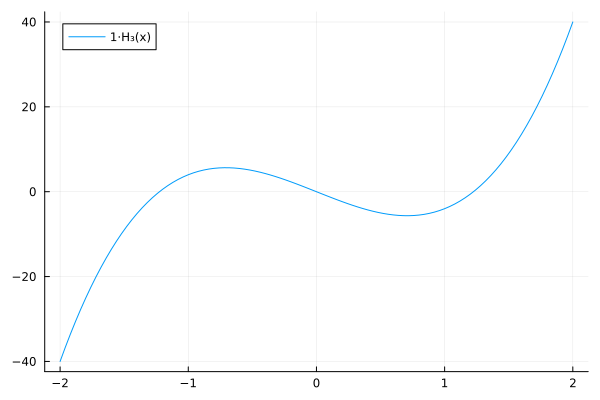

In [23]:
h3 = Hermite([0, 0, 0, 1])
plot(h3, -2, 2)

Żeby nie podawać wektora ze współczynnikami kolejnych stopni, można zrobić inaczej

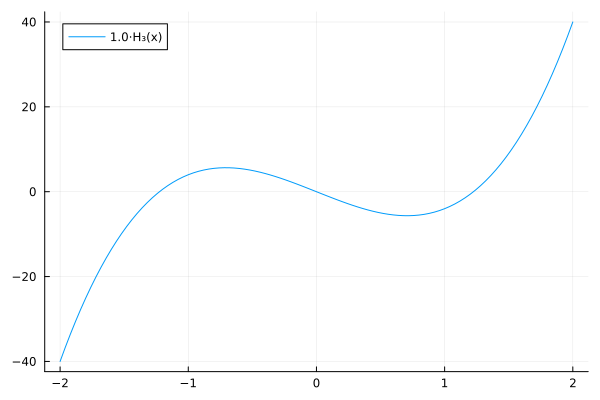

In [24]:
h4 = basis(Hermite, 3)
plot(h4, -2, 2)

### Przykład aproksymacji

Spróbujemy dokonać aproksymacji zaszumionej funkcji `cos` wykorzystując rodzinę wielomianów ortogonalnych Hermite'a.

In [25]:
# Definicja węzłów
xx = -5:0.1:5
yy = cos.(xx/3 .+.2).^2 .+ rand(length(xx))/5;

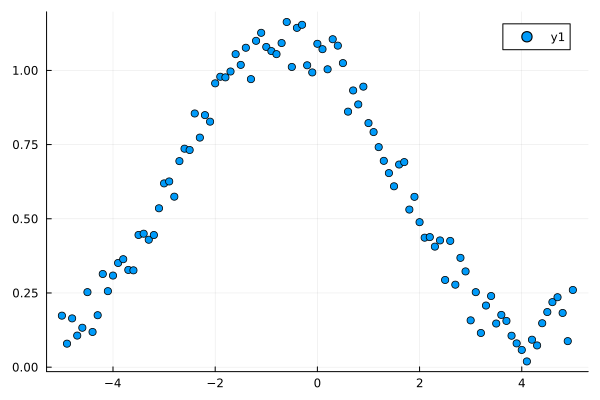

In [26]:
scatter(xx, yy, markershape=:circle)

Obliczony wektor wartości normalizujemy do 1, żeby łatwiej policzyć współczynniki aproksymacji (niżej objaśnienie dlaczego łatwiej). 

In [27]:
#przykład prostego wektora, który znormalizujemy
vec=[2,2,2,2]

4-element Vector{Int64}:
 2
 2
 2
 2

In [28]:
# iloczyn skalarny = długość^2
dot(vec,vec)

16

In [29]:
# normalizacja - długość wektora =1
normalize(vec)

4-element Vector{Float64}:
 0.5
 0.5
 0.5
 0.5

In [30]:
# sprawdzamy długość^2
dot(normalize(vec), normalize(vec))

1.0

* 0bliczamy funkcję bazową uwzględniającą czynnik wagowy.
$<P_m,P_n>=\int_{-\infty}^{\infty} H_n(x)H_m(x)\exp(-x^2)dx 
= \int_{-\infty}^{\infty}\underbrace{H_n(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_n}\underbrace{H_m(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_m}$

* Wyliczamy jej wartości dla podanych punktów x
* Otrzymany wektor wartości normalizujemy


In [31]:
# obliczamy funkcję bazową
# argument 'norm'  na potrzeby wykresów
function base_fun(k, x, norm=true)
    H_k = basis(Hermite, k).(x)
    app = H_k .* exp.(-(x.^2)/2)
    # normalize to have norm 1
    if norm
        return normalize(app)
    end
    return app
end

base_fun (generic function with 2 methods)

In [32]:
y_2_unnorm = base_fun(2, xx, false);
y_2_norm = base_fun(2, xx);

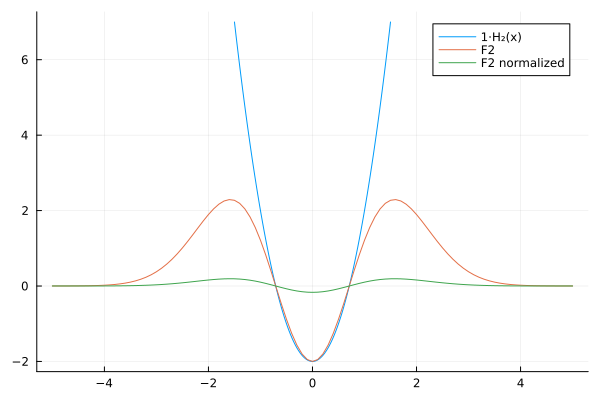

In [33]:
plot(Hermite([0, 0, 1]), -1.5, 1.5)
plot!(xx, y_2_unnorm, label="F2")
plot!(xx, y_2_norm, label="F2 normalized")

Obliczamy wektory wartosci dla punktów w xx dla kilku kolejnych funkcji bazowych

In [34]:
f0 = base_fun(0, xx, true);
f1 = base_fun(1, xx, true);
f2 = base_fun(2, xx, true);
f3 = base_fun(3, xx, true);

Sprawdźmy czy baza jest ortonormalna (uwaga: zamiast liczyć całkę, sprawdzamy po prostu iloczyn skalarny wektorów wartości. Jeśli wartości są wystarczająco "gęsto" jest do dobre przybliżenie).

In [35]:
dot_base = Array{Float64, 2}(undef, 4, 4); 

for (i, f_i) in enumerate([f0, f1, f2, f3]) 
    for (j, f_j) in enumerate([f0, f1, f2, f3])
        dot_base[i,j] = dot(f_i, f_j)
    end
end

In [36]:
dot_base

4×4 Matrix{Float64}:
  1.0           9.17832e-18  -3.25356e-11   1.85612e-18
  9.17832e-18   1.0           1.88742e-17  -9.61163e-10
 -3.25356e-11   1.88742e-17   1.0          -7.22228e-18
  1.85612e-18  -9.61163e-10  -7.22228e-18   1.0

OK, baza jest ortonormalna

Obliczamy kolejne współczynniki aproksymacji. Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funkcji aproksymowanej oraz  wektora bazowego (analogia: rzut  wektora wartości funkcji aproksymowanej w kierunku wektora bazowego).

Wektor bazowy jest znormalizowany $|\vec{j}|=1$, co upraszcza obliczenia.

Analogia w 2D

$\text{rzut }\vec{a} \text{ w kierunku }  \vec{j} =|\vec{a}|\cdot cos(\angle(\vec{a},\vec{j}))=|\vec{a}|\cdot|\vec{j}|\cdot cos(\angle(\vec{a},\vec{j}))=dot(\vec{a},\vec{j})$

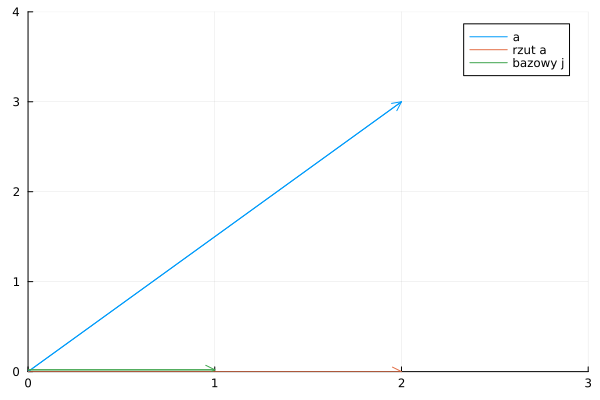

In [37]:
plot([0,2],[0,3],xrange=[0,3], yrange=[0,4],arrow=true, label="a")
plot!([0,2],[0,0],xrange=[0,3], yrange=[0,4],arrow=true, label="rzut a")
plot!([0,1],[0.02,0.02],xrange=[0,3], yrange=[0,4],arrow=true, label="bazowy j")

In [38]:
c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c0, c1, c2, c3

(5.786674717491039, -0.9179994016425825, 2.6891902476524874, -0.814264087961545)

Liczymy wartości aproksymowane kolejnymi stopniami

In [39]:
y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;

In [40]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;

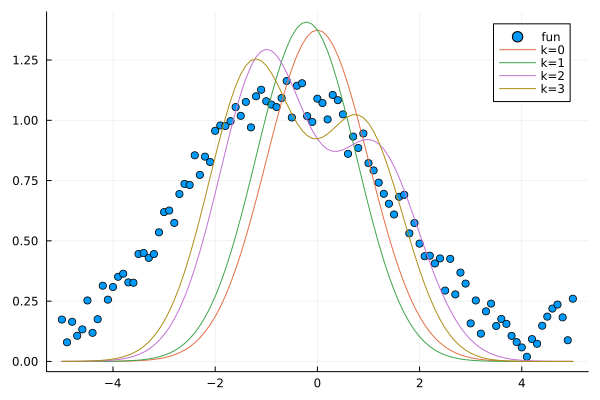

In [41]:
scatter(xx, yy, markershape=:circle, label="fun")
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")

Liczymy błędy aproksymacji kolejnymi stopniami

In [42]:
using Statistics

In [43]:
mse(y1, y2) = mean((y1-y2).^2)

mse (generic function with 1 method)

In [44]:
mse(yy, y_app_0)

0.12876989205833134

In [45]:
mse(yy, y_app_01)

0.1204261009552012

In [46]:
mse(yy, y_app_012)

0.04882467334052943

In [47]:
mse(yy, y_app_0123)

0.042260059415967326

### EKG

Dane pochodzą z bazy https://www.physionet.org/content/mitdb/1.0.0/ .

W sygnale można wyróżnić wiele struktur, z których najbardziej charakterystyczną jest zespół QRS.

In [48]:
ekg_data = CSV.read("ecg_data.csv", DataFrame);

In [49]:
first(ekg_data, 5)

Row,time,signalN,signalV
,Float64,Float64,Float64
1,-0.1,0.0183886,-0.0990972
2,-0.0972222,0.0145191,-0.0920442
3,-0.0944444,0.012849,-0.0831644
4,-0.0916667,0.0124946,-0.0722728
5,-0.0888889,0.0124117,-0.0593656


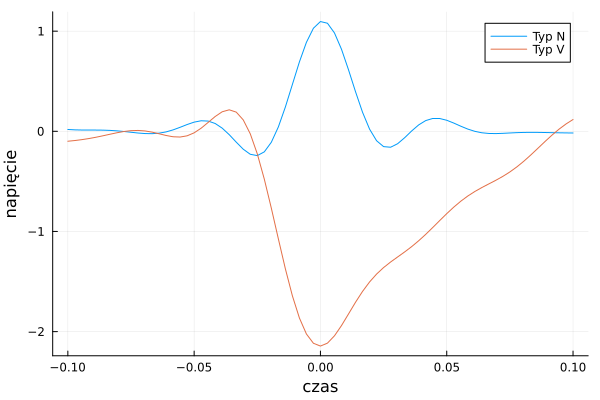

In [50]:
plot(ekg_data.time, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(ekg_data.time, ekg_data.signalV, label="Typ V")

(5.725113911598116, -0.9157906158817669, 2.711325477169205, -0.8018390195854078)

Uwaga: Funkcje bazowe mają pewną "szerokość" i najlepiej aproksymują inne funkcje o podobnej szerokości. Można dodatkowo sparametryzować f. bazowe aby były węższe i lepiej pasowały do zespołów QRS. Na potrzeby laboratorium postąpimy inaczej - przeskalujemy oś X aproksymowanych sygnałów.

In [51]:
# Definicja węzłów
xx_ekg = ekg_data.time*40
yy_ekgV = ekg_data.signalV;

## Zadania

#### Zadanie 1 (1 pkt)

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2) $H_m(x)$, $m \in \{0,1,...,5\}$

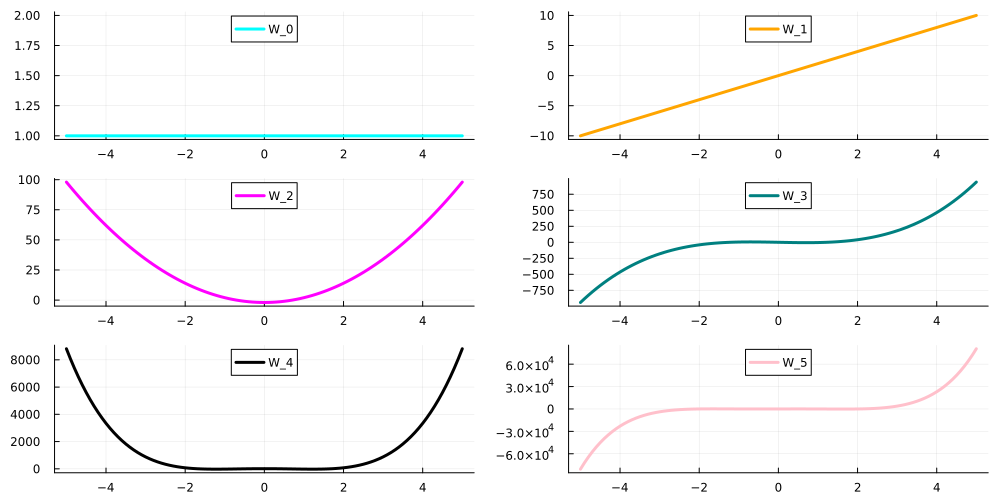

In [52]:
xs = -5:0.1:5
h0 = basis(Hermite,0)
h1 = basis(Hermite,1)
h2 = basis(Hermite,2)
h3 = basis(Hermite,3)
h4 = basis(Hermite,4)
h5 = basis(Hermite,5)
ys0 = h0.(xs)
ys1 = h1.(xs)
ys2 = h2.(xs)
ys3 = h3.(xs)
ys4 = h4.(xs)
ys5 = h5.(xs)
plot(
    size = (1000,500),
    linewidth=3,
    xs,
    [ys0,ys1,ys2,ys3,ys4,ys5],
    layout=grid(3,2),
    color = [:cyan :orange :magenta :teal :black :pink],
    label = ["W_0" "W_1" "W_2" "W_3" "W_4" "W_5"],
    legend_position = :top
)

Podobnie  narysować 6 pierwszych funkcji bazowych z uwzględnieniem czynnika wagowego $H_m(x)\exp(-\frac{x^2}{2})$, $m \in \{0,1,...,5\}$

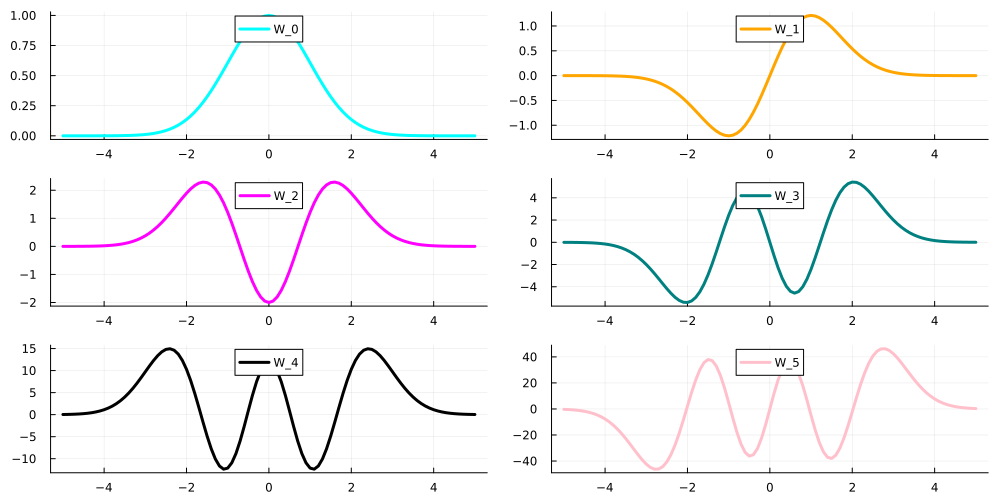

In [ ]:
ys0_w = ys0 .* exp.(-(xs.^2)/2)
ys1_w = ys1 .* exp.(-(xs.^2)/2)
ys2_w = ys2 .* exp.(-(xs.^2)/2)
ys3_w = ys3 .* exp.(-(xs.^2)/2)
ys4_w = ys4 .* exp.(-(xs.^2)/2)
ys5_w = ys5 .* exp.(-(xs.^2)/2)

plot(
    size = (1000,500),
    linewidth=3,
    xs,
    [ys0_w,ys1_w,ys2_w,ys3_w,ys4_w,ys5_w],
    layout=grid(3,2),
    color = [:cyan :orange :magenta :teal :black :pink],
    label = ["W_0" "W_1" "W_2" "W_3" "W_4" "W_5"],
    legend_position = :top
)

#### Zadanie 2 (1 pkt)

Pokazać, że same wielomiany nie są ortogonane, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

In [ ]:
xs = -6:0.1:6

# Wielomiany bazowe Hermite'a
b0 = h0.(xs)
b1 = h1.(xs)
b2 = h2.(xs)
b3 = h3.(xs)
b4 = h4.(xs)
b5 = h5.(xs)

ys0 = normalize(
    h0.(xs) .* exp.((-xs.^2)/2)
)
ys1 = normalize(
    h1.(xs) .* exp.((-xs.^2)/2)
)
ys2 = normalize(
    h2.(xs) .* exp.((-xs.^2)/2)
)
ys3 = normalize(
    h3.(xs) .* exp.((-xs.^2)/2)
)
ys4 = normalize(
    h4.(xs) .* exp.((-xs.^2)/2)
)
ys5 = normalize(
    h5.(xs) .* exp.((-xs.^2)/2)
)

no_wage = Array{Float64, 2}(undef, 6, 6); 
with_wage = Array{Float64, 2}(undef, 6, 6); 
for (i, b_i) in enumerate([b0, b1, b2, b3, b4, b5]) 
    for (j, b_j) in enumerate([b0, b1, b2, b3, b4, b5])
        no_wage[i,j] = dot(b_i, b_j)
    end
end
for (i, ys_i) in enumerate([ys0, ys1, ys2, ys3, ys4, ys5]) 
    for (j, ys_j) in enumerate([ys0, ys1, ys2, ys3, ys4, ys5])
        with_wage[i,j] = dot(ys_i, ys_j)
    end
end

In [88]:
no_wage

6×6 Matrix{Float64}:
  121.0            -1.06581e-14  5662.8          …  4.49225e5    -2.61934e-10
   -1.06581e-14  5904.8             3.18323e-12     4.36557e-10   4.42057e7
 5662.8             3.18323e-12     4.95495e5       4.71729e7     5.96046e-8
   -2.27374e-13     4.83202e5       2.03727e-10     1.49012e-8    4.85403e9
    4.49225e5       4.36557e-10     4.71729e7       4.95669e9     4.76837e-7
   -2.61934e-10     4.42057e7       5.96046e-8   …  4.76837e-7    5.19167e11

In [89]:
with_wage

6×6 Matrix{Float64}:
 17.7245       -3.25918e-17  …    -4.08374e-12     -5.07403e-15
 -3.25918e-17  35.4491            -1.65908e-14     -5.82992e-10
 -2.8367e-14   -2.38444e-16       -6.08838e-10     -2.77175e-14
  7.79996e-16  -4.25083e-12       -2.98963e-15     -8.46122e-8
 -4.08374e-12  -1.65908e-14     6806.22             1.27418e-13
 -5.07403e-15  -5.82992e-10  …     1.27418e-13  68062.2

#### Zadanie 3  (1 pkt)

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

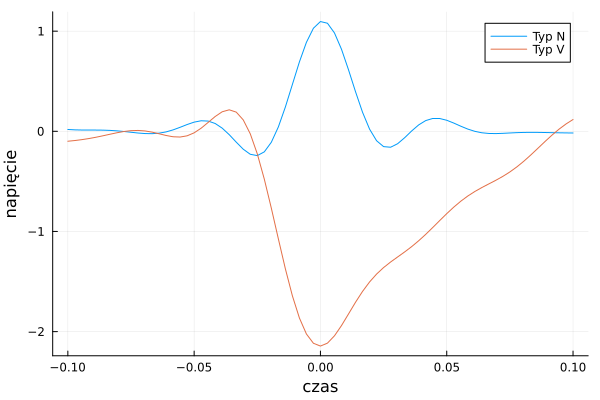

In [ ]:
# Wczytanie danych
ekg_data = CSV.read("ecg_data.csv", DataFrame)
plot(ekg_data.time, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(ekg_data.time, ekg_data.signalV, label="Typ V")

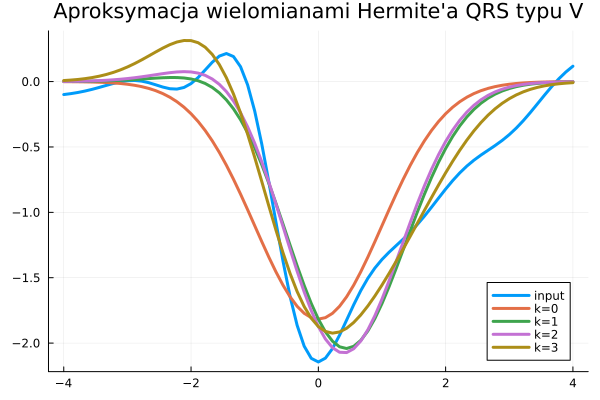

In [104]:
function base_fun(k, x, norm=true)
    H_k = basis(Hermite, k).(x)
    app = H_k .* exp.(-(x.^2)/2)
    if norm
        return normalize(app)
    end
    return app
end

# Przygotowanie danych
xx_ekg = ekg_data.time*40
yy_ekgV = ekg_data.signalV

# Oblicznanie kolejnych funkcji bazowy Hermite'a z wagą
ys0 = base_fun(0,xx_ekg)
ys1 = base_fun(1, xx_ekg)
ys2 = base_fun(2, xx_ekg)
ys3 = base_fun(3, xx_ekg)

# Obliczanie wspolczynnika aproksymacji
c0 = dot(yy_ekgV, ys0)
c1 = dot(yy_ekgV, ys1)
c2 = dot(yy_ekgV, ys2)
c3 = dot(yy_ekgV, ys3)

# Aproksymacja korzystając z kolejnych wielomianów Hermite'a
V0 = c0 * ys0
V1 = c1 * ys1
V2 = c2 * ys2
V3 = c3 * ys3
V01 = V0 + V1
V012 = V01 + V2
V0123 = V012 + V3

plot(
    xx_ekg, 
    [yy_ekgV,V0,V01,V012,V0123],
    label=["input" "k=0" "k=1" "k=2" "k=3"],
    linewidth=3,
    title="Aproksymacja wielomianami Hermite'a QRS typu V"
)

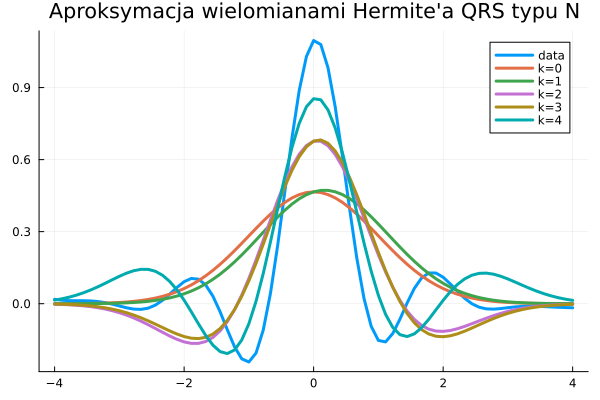

In [ ]:
yy_ekgN = ekg_data.signalN
n = length(xx_ekg)

# Oblicz składniki aproksymacji (0 ≤ k ≤ 10)
approx = [begin
    y = base_fun(i, xx_ekg)
    c = dot(yy_ekgN, y)
    c * y
end for i in 0:10]

# Suma częściowa przybliżeń: cumsum([a, b, c, d]) == [a, a+b, a+b+c, a+b+c+d]
cumulative_approx = cumsum(approx)

plot(
    xx_ekg,
    [yy_ekgN, cumulative_approx[1:5]...],
    label=["data" "k=0" "k=1" "k=2" "k=3" "k=4"],
    linewidth=3,
    title="Aproksymacja wielomianami Hermite'a QRS typu N"
)

#### Zadanie 4  (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?

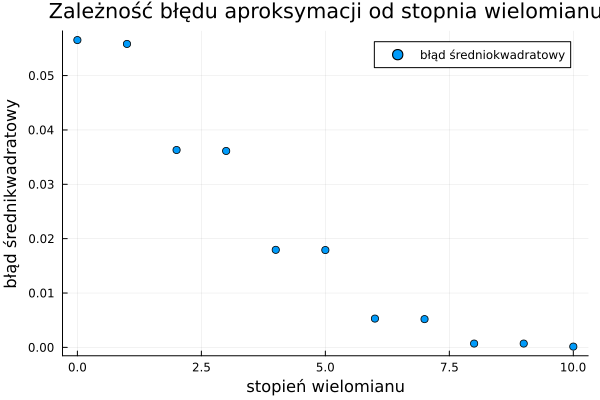

In [103]:
mse(y1, y2) = mean((y1-y2).^2)
epsilon = [mse(yy_ekgN, cumulative_approx[k]) for k in 1:11]
scatter( 
    0:1:10,
    epsilon,
    xlabel="stopień wielomianu",
    ylabel="błąd średnikwadratowy",
    label="błąd średniokwadratowy",
    title="Zależność błędu aproksymacji od stopnia wielomianu"
)

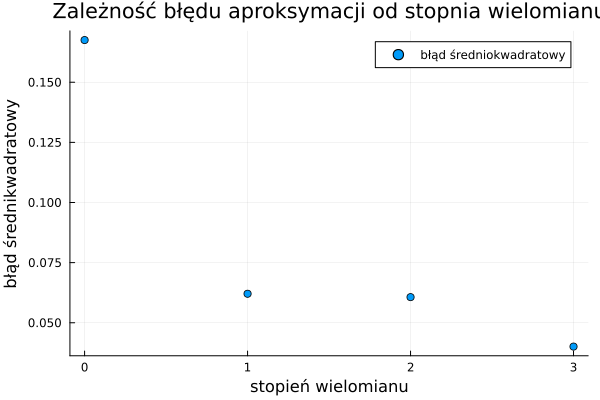

In [117]:
mse(y1, y2) = mean((y1-y2).^2)
cumulative_approx = [V0, V01, V012, V0123]
epsilon = [mse(yy_ekgV, cumulative_approx[k]) for k in 1:4]
scatter( 
    0:1:3,
    epsilon,
    xlabel="stopień wielomianu",
    ylabel="błąd średnikwadratowy",
    label="błąd średniokwadratowy",
    title="Zależność błędu aproksymacji od stopnia wielomianu"
)